<a href="https://colab.research.google.com/github/deathperminut/DoctorDegree/blob/main/Paper1/CuadernillosModelos/ResNetUnivariado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## CARGAMOS LA BASE DE DATOS

In [ ]:
# Crear la carpeta .kaggle si no existe
os.makedirs("/root/.kaggle", exist_ok=True)
# Mover el archivo kaggle.json a la carpeta
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
# Dar permisos adecuados
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d deathperminut/material-spinners-data

Dataset URL: https://www.kaggle.com/datasets/deathperminut/material-spinners-data
License(s): CC0-1.0
 82% 104M/126M [00:00<00:00, 174MB/s] 
100% 126M/126M [00:00<00:00, 158MB/s]


In [ ]:
# Nombre del archivo descargado (ajústalo según sea necesario)
dataset_zip = "/content/material-spinners-data.zip"
# Extraer los archivos
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Ver archivos extraídos
os.listdir("dataset")

['data.npy.npz', '__notebook__.ipynb']

In [ ]:
#load data
file_ = '/content/dataset/data.npy.npz'
data = np.load(file_)
MS,Nest,L,rd,So,T,Jex,Jex2,Jex3,Jex4,Kan1,KanS,Hex,kd,KDM = data['MS'],data['Nest'],data['L'],data['rd'],data['So'],data['T'],data['Jex'],data['Jex2'],data['Jex3'],data['Jex4'],data['Kan1'],data['KanS'],data['Hex'],data['kd'],data['KDM']

## JEX 2

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex2.reshape(-1, 1)
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:
# Preprocesamiento para adaptar a ResNet
inputs = tf.keras.Input(shape=(39, 39, 1))

In [ ]:

# Preprocesamiento para adaptar a ResNet
inputs = tf.keras.Input(shape=(39, 39, 1))

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar la base preentrenada

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,143 (90.98 MB)

 Trainable params: 262,431 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - loss: 0.1240 - mae: 0.2075 - val_loss: 0.0159 - val_mae: 0.1030
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - loss: 0.0249 - mae: 0.1239 - val_loss: 0.0158 - val_mae: 0.1046
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0246 - mae: 0.1230 - val_loss: 0.0153 - val_mae: 0.1011
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0236 - mae: 0.1205 - val_loss: 0.0187 - val_mae: 0.1074
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0219 - mae: 0.1142 - val_loss: 0.0139 - val_mae: 0.0937
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0206 - mae: 0.1106 - val_loss: 0.0131 - val_mae: 0.0908
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0202 - mae: 0.1094 - val_loss: 0.0139 - val_mae: 0.0948
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0198 - mae: 0.1078 - val_loss: 0.0121 - val_mae: 0.0869
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = model.predict(X_val)

338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step


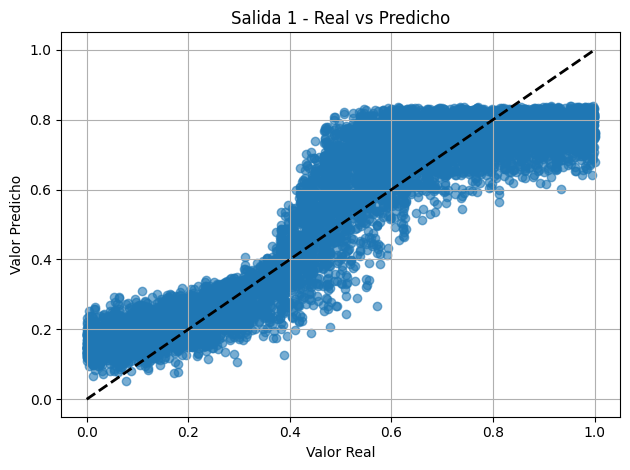

In [ ]:
# Las predicciones del modelo devuelven dos salidas: imagen y parámetros
# Hacer predicciones con el modelo entrenado
#y_pred = model.predict(x_val)  # Predicciones en los datos de validación
plt.scatter(y_val_scaled[:,0], y_pred[:, 0], alpha=0.6)
plt.plot([min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], [min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], 'k--', lw=2)  # Línea de igualdad
plt.title(f'Salida {0+1} - Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.012113869988913444
mae:  0.08751963204644567
rmse:  0.012113869988913444


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")

R²: 0.8584


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

MAPE: 128.36%


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 27.07%


## T

In [ ]:
X_ = MS[:,:,:,:]
Y_ = T.reshape(-1, 1)
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:

# Preprocesamiento para adaptar a ResNet
inputs = tf.keras.Input(shape=(39, 39, 1))

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar la base preentrenada

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,143 (90.98 MB)

 Trainable params: 262,431 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 0.1326 - mae: 0.2260 - val_loss: 0.0405 - val_mae: 0.1462
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0392 - mae: 0.1481 - val_loss: 0.0330 - val_mae: 0.1320
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0336 - mae: 0.1359 - val_loss: 0.0301 - val_mae: 0.1297
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - loss: 0.0316 - mae: 0.1327 - val_loss: 0.0284 - val_mae: 0.1223
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - loss: 0.0289 - mae: 0.1263 - val_loss: 0.0268 - val_mae: 0.1211
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - loss: 0.0285 - mae: 0.1247 - val_loss: 0.0243 - val_mae: 0.1140
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - loss: 0.0272 - mae: 0.1204 - val_loss: 0.0246 - val_mae: 0.1156
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - loss: 0.0263 - mae: 0.1171 - val_loss: 0.0242 - val_mae: 0.1128
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = model.predict(X_val)

338/338 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step


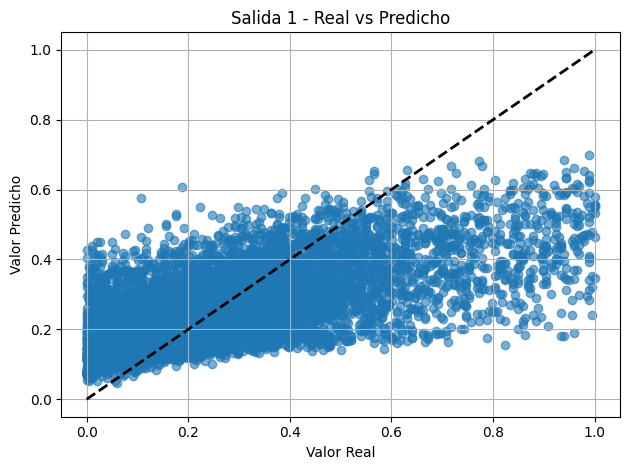

In [ ]:
# Las predicciones del modelo devuelven dos salidas: imagen y parámetros
# Hacer predicciones con el modelo entrenado
#y_pred = model.predict(x_val)  # Predicciones en los datos de validación
plt.scatter(y_val_scaled[:,0], y_pred[:, 0], alpha=0.6)
plt.plot([min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], [min(y_val_scaled[:, 0]), max(y_val_scaled[:, 0])], 'k--', lw=2)  # Línea de igualdad
plt.title(f'Salida {0+1} - Real vs Predicho')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.02126180623078326
mae:  0.10316895694074604
rmse:  0.02126180623078326


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")

R²: 0.4788


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

MAPE: 141.15%


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 53.69%


## JEX 3

In [ ]:
X_ = MS[:,:,:,:]
Y_ = Jex3.reshape(-1, 1)
# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2, random_state=42) ## STRATIGICADO

# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

In [ ]:

# Preprocesamiento para adaptar a ResNet
inputs = tf.keras.Input(shape=(39, 39, 1))

# Convertir de escala de grises (1 canal) a RGB (3 canales)
x = layers.Conv2D(3, (3, 3), padding="same", activation="relu")(inputs)  # Convertir a 3 canales

# Redimensionar la imagen a (224, 224), tamaño esperado por ResNet50 usando tf.image.resize
x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(x)

# Cargar ResNet50 como base sin las capas finales (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar la base preentrenada

# Pasar la entrada por el modelo base (ResNet50)
x = base_model(x)

# Añadir un GlobalAveragePooling para reducir la dimensionalidad
x = layers.GlobalAveragePooling2D()(x)

# Capa densa con Dropout
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Capa de salida con 4 valores (para regresión)
outputs = layers.Dense(1, activation='linear')(x)

# Definir el modelo
model = tf.keras.Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Resumen del modelo
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 39, 39, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 39, 39, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,143 (90.98 MB)

 Trainable params: 262,431 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_val, y_val_scaled),
    epochs=10,  # Ajusta según tus datos
    batch_size=64,  # Tamaño de lote
    verbose=1
)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 55s 66ms/step - loss: 0.2616 - mae: 0.3529 - val_loss: 0.0847 - val_mae: 0.2545
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - loss: 0.0947 - mae: 0.2627 - val_loss: 0.0848 - val_mae: 0.2545
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - loss: 0.0886 - mae: 0.2570 - val_loss: 0.0845 - val_mae: 0.2546
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0838 - mae: 0.2517 - val_loss: 0.0845 - val_mae: 0.2548
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0838 - mae: 0.2530 - val_loss: 0.0846 - val_mae: 0.2547
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 0.0836 - mae: 0.2524 - val_loss: 0.0847 - val_mae: 0.2547
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0832 - mae: 0.2517 - val_loss: 0.0847 - val_mae: 0.2547
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - loss: 0.0836 - mae: 0.2528 - val_loss: 0.0847 - val_mae: 0.2549
Epoch 9/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Realiza las predicciones usando el modelo
y_pred = model.predict(X_val)

338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_val_scaled[:,0],  y_pred[:,0])
mae =  mean_absolute_error(y_val_scaled[:,0], y_pred[:,0])
rmse =  mean_squared_error(y_val_scaled[:,0], y_pred[:,0])
#########################################
####                          ###########
#########################################
print('mse: ',mse)
print('mae: ',mae)
print('rmse: ',rmse)

mse:  0.08467388202271314
mae:  0.25488022580188496
rmse:  0.08467388202271314


In [ ]:
from sklearn.metrics import r2_score

# Calcular R²
r2 = r2_score(y_val_scaled[:,0], y_pred[:,0])
print(f"R²: {r2:.4f}")

R²: -0.0000


In [ ]:
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Filtrar valores donde y_true es diferente de 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_val_scaled[:,0], y_pred[:,0])
print(f"MAPE: {mape:.2f}%")

MAPE: 278.76%


In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calcular SMAPE
smape_value = smape(y_val_scaled[:,0], y_pred[:,0])
print(f"SMAPE: {smape_value:.2f}%")

SMAPE: 59.51%
